# Label Distribution Plot
We define a step of a random walk as $A * P(N)$ where $A$ is the adjacency matrix of a (PPI) network and $P(N)$ is the distribution of labels. $P(i) > 0$ means that the node is labeled in the graph.

We then look at the number of steps needed for $P(N)$ to become greater than $0$ for all nodes. This could be an estimate as to how many layers of GCN we'd need.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import h5py

import gcnIO, os

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

In [2]:
model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feature_names = data
print (args)

{'epochs': 5000, 'loss_mul': 45.0, 'support': 1, 'hidden_dims': [300, 100], 'decay': 0.005, 'dropout': 0.5, 'lr': 0.001, 'cv_runs': 10, 'data': '../data/pancancer/all_omics_final_CPDB/CPDB_multiomics.h5'}


In [3]:
if not val_mask is None:
    p_0_all = np.logical_or(np.logical_or(train_mask, test_mask), val_mask)
    p_0_pos = np.logical_or(np.logical_or(y_train, y_test), y_val)
else:
    p_0_all = np.logical_or(train_mask, test_mask)
    p_0_pos = np.logical_or(y_train, y_test)

p_0_neg = np.logical_xor(p_0_pos.reshape(-1), p_0_all)

p_0_all = p_0_all / p_0_all.sum()
p_0_pos = p_0_pos / p_0_pos.sum()
p_0_neg = p_0_neg / p_0_neg.sum()

In [4]:
# load the known cancer genes and candidate cancer genes
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('Name')
candidates_innet = nodes.index.isin(candidate_cancer_genes).sum()
negatives = nodes[p_0_neg != 0]
p_0_candidates = nodes.index.isin(candidate_cancer_genes)

In [5]:
rw_all = [p_0_all]
rw_pos = [p_0_pos]
rw_neg = [p_0_neg]
rw_candidates = [p_0_candidates]
for i in range(5):
    p_i_all = adj.dot(rw_all[-1])
    rw_all.append(p_i_all)
    
    p_i_pos = adj.dot(rw_pos[-1])
    rw_pos.append(p_i_pos)
    
    p_i_neg = adj.dot(rw_neg[-1])
    rw_neg.append(p_i_neg)
    
    p_i_candidates = adj.dot(rw_candidates[-1])
    rw_candidates.append(p_i_candidates)

In [13]:
np.count_nonzero(rw_pos[1])

9784

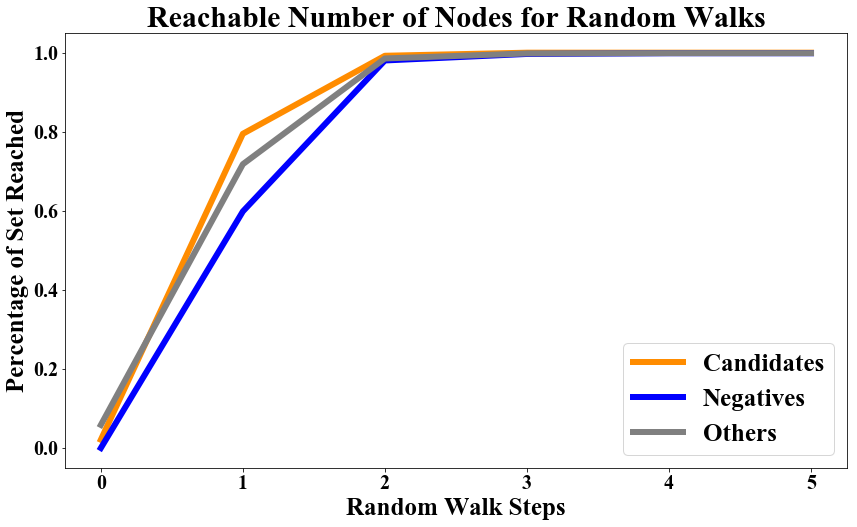

In [14]:
fig = plt.figure(figsize=(14, 8))
#plt.plot([0, len(rw_all)-1], [1, 1], color='gray', lw=6, linestyle='--', label='# Candidate Cancer Genes')
#plt.plot([np.count_nonzero(i) for i in rw_pos], c='red', lw=6, label='Known Cancer Genes')
plt.plot([nodes[i != 0].index.isin(candidate_cancer_genes).sum() / candidates_innet for i in rw_pos], c='darkorange', lw=6,
         label='Candidates')
plt.plot([nodes[i != 0].index.isin(negatives.index).sum() / negatives.shape[0] for i in rw_pos], c='blue', lw=6,
         label='Negatives')
plt.plot([np.count_nonzero(i) / adj.shape[0] for i in rw_pos], lw=6, color='grey', label='Others')
plt.xlabel('Random Walk Steps', fontsize=25)
plt.ylabel('Percentage of Set Reached', fontsize=25)
plt.tick_params(axis='both', labelsize=20)
plt.legend(fontsize=25)
plt.title('Reachable Number of Nodes for Random Walks', fontsize=30)
fig.savefig(os.path.join(model_dir, 'candidate_reachability_from_known.svg'))

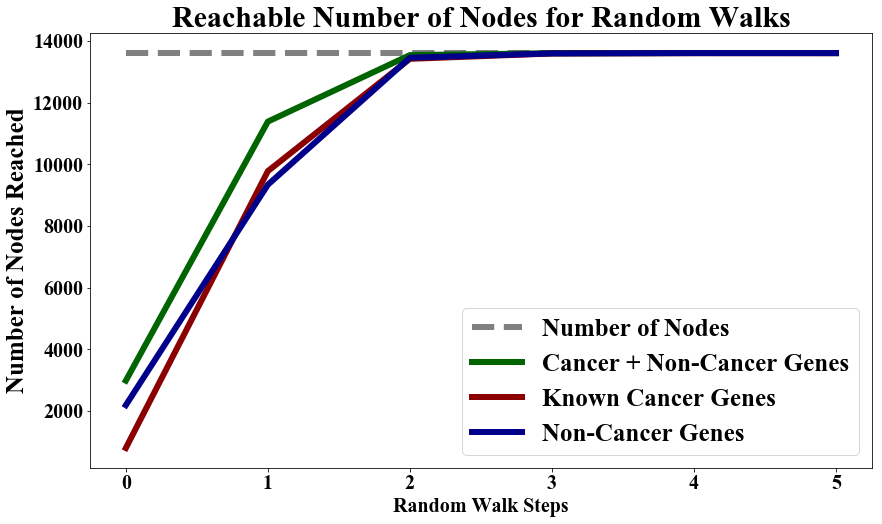

In [17]:
fig = plt.figure(figsize=(14, 8))
plt.plot([0, len(rw_all)-1], [adj.shape[0], adj.shape[0]], color='gray', lw=6, linestyle='--', label='Number of Nodes')
plt.plot([np.count_nonzero(i) for i in rw_all], c='darkgreen', lw=6, label='Cancer + Non-Cancer Genes')
plt.plot([np.count_nonzero(i) for i in rw_pos], c='darkred', lw=6, label='Known Cancer Genes')
plt.plot([np.count_nonzero(i) for i in rw_neg], c='darkblue', lw=6, label='Non-Cancer Genes')
plt.xlabel('Random Walk Steps', fontsize=20)
plt.ylabel('Number of Nodes Reached', fontsize=25)
plt.tick_params(axis='both', labelsize=20)

plt.legend(loc='lower right', fontsize=25)
plt.title('Reachable Number of Nodes for Random Walks', fontsize=30)
fig.savefig(os.path.join(model_dir, 'random_walk_reachability.svg'))

In [18]:
np.count_nonzero(rw_pos[1])

9784